# State

In [1]:
import numpy as np
import cupy as cp
from scipy.linalg import inv, expm
import networkx as nx
import time
import cupyx.scipy.linalg as cpx_scipy
import sympy as sp
import cupy as cp


from __future__ import annotations
from typing import Union

import json

from qwak.Errors import StateOutOfBounds, NonUnitaryState, MissingNodeInput
from utils.PerfectStateTransfer import isStrCospec, checkRoots, swapNodes, getEigenVal

from utils.jsonTools import json_matrix_to_complex, complex_matrix_to_json

class CupyState:
    def __init__(self, n: int, nodeList: list = None,
                 customStateList: list = None) -> None:
        """Object is initialized with a mandatory user-inputted dimension, an optional
        stateList parameter which will be used to create the amplitudes for each node in the state
        and an internal stateVec which will be a cupy ndarray representing the column vector.

        Parameters
        ----------
        n : int
            Desired dimension of the state.
        nodeList : list, optional
            List containing what nodes will have uniform superposition in the state, by default None.
        customStateList : list, optional
            Custom amplitudes for the state, by default None.
        """
        self._n = n
        if nodeList is None:
            self._nodeList = cp.array([])  # Use cupy array
        else:
            self._nodeList = cp.array(nodeList)  # Ensure it's a cupy array

        if customStateList is None:
            self._customStateList = cp.array([])  # Use cupy array
        else:
            self._customStateList = cp.array(customStateList)  # Ensure it's a cupy array

        self._stateVec = cp.zeros((self._n, 1), dtype=complex)  # Create a cupy array with zeros

    def buildState(
            self,
            nodeList: list = None,
            customStateList: list = None) -> None:
        """Builds state vector from state list, by creating a balanced superposition of all
        nodes in the nodeList.
        This will be changed in the future to make nodeList make more sense.

        Parameters
        ----------
        nodeList : list, optional
            List containing what nodes will have uniform superposition in the state, by default None.
        customStateList : list, optional
            Custom amplitudes for the state, by default None.
        """
        if nodeList is not None:
            self.resetState()
            self._nodeList = cp.array(nodeList)#, dtype=complex)  # Ensure it's a cupy array
        if customStateList is not None:
            self.resetState()
            self._customStateList = cp.array(customStateList, dtype=complex)  # Ensure it's a cupy array
        if self._customStateList:
            self._checkUnitaryStateList(self._customStateList)
            for customState in self._customStateList:
                self._checkStateOutOfBounds(customState[0])
                self._stateVec[customState[0]] = customState[1]
        else:
            nodeAmp = cp.sqrt(len(self._nodeList))
            for state in self._nodeList:
                state = int(state)
                self._checkStateOutOfBounds(state)
                self._stateVec[state] = 1 / nodeAmp

    def _checkStateOutOfBounds(self, node: int) -> None:
        """Checks if the state is out of bounds for the system.

        Parameters
        ----------
        node : int
            Node to check.

        Raises
        ------
        StateOutOfBounds
            Out of bounds exception.
        """
        if node >= self._n:
            raise StateOutOfBounds(
                f"State {node} is out of bounds for system of size {self._n} ([0-{self._n - 1}])."
            )

    def _checkUnitaryStateList(self, customStateList) -> None:
        """Checks if the sum of the square of the amplitudes is 1.

        Parameters
        ----------
        customStateList : list
            Custom state list.

        Raises
        ------
        NonUnitaryState
            Non unitary state exception.
        """
        unitaryState = 0
        for state in customStateList:
            unitaryState += cp.abs(state[1]) ** 2
        unitaryState = round(unitaryState, 5)
        if unitaryState != float(1):
            raise NonUnitaryState(
                f"The sum of the square of the amplitudes is -- {unitaryState} -- instead of 1."
            )

    def herm(self) -> cp.ndarray:
        """Returns the Hermitian conjugate of the state vector.

        Returns
        -------
        np.ndarray
            Hermitian conjugate of the state vector.
        """
        return self._stateVec.H

    def inv(self) -> cp.ndarray:
        """Returns the inverse of the state vector.

        Returns
        -------
        np.ndarray
            Inverse of the state vector.
        """
        return inv(self._stateVec)

    def resetState(self) -> None:
        """Resets the components of the State."""
        self._stateVec = cp.zeros((self._n, 1), dtype=complex)

    def setDim(self, newDim: int, newNodeList: list = None) -> None:
        """Sets the current state dimension to a user defined one.

        Parameters
        ----------
        newDim : int
            New state dimension.
        newNodeList : list, optional
            List containing the new nodes, by default None.
        """
        self._n = newDim
        self._stateVec = cp.zeros((self._n, 1), dtype=complex)
        if newNodeList is not None:
            self._nodeList = newNodeList

    def getDim(self) -> int:
        """Gets the current state dimension.

        Returns
        -------
        int
            State dimension.
        """
        return self._n

    def setNodeList(self, newNodeList: list) -> None:
        """Sets current node list to a user inputted one.

        Parameters
        ----------
        newNodeList : list
            List containing the new nodes.
        """
        self._nodeList = newNodeList

    def getNodeList(self) -> list:
        """Gets the current list of nodes.

        Returns
        -------
        list
            Current list of nodes.
        """
        return self._nodeList

    def setStateVec(self, newVec: cp.ndarray) -> None:
        """Sets the column vector associated with the state to a user defined one.

        Parameters
        ----------
        newVec : np.ndarray
            New column vector for the state.
        """
        self._stateVec = newVec

    def getStateVec(self) -> cp.ndarray:
        """Gets the column vector associated with the state.

        Returns
        -------
        np.ndarray
            Vector of the State.
        """
        return self._stateVec

    def setState(self, newState: State) -> None:
        """Sets all the parameters of the current state to user defined ones.

        Parameters
        ----------
        newState : State
            New state.
        """
        self._n = newState.getDim()
        self._nodeList = newState.getNodeList()
        self._stateVec = newState.getStateVec()


    def __mul__(self, other: cp.ndarray) -> cp.ndarray:
        """Left-side multiplication for the State class.

        Parameters
        ----------
        other : np.ndarray
            Another Numpy ndarray to multiply the state by.

        Returns
        -------
        np.ndarray
            Array of the multiplication
        """
        return self._stateVec * other

    def __rmul__(self, other: cp.ndarray) -> cp.ndarray:
        """Left-side multiplication for the State class.

        Parameters
        ----------
        other : np.ndarray
            Another Numpy ndarray to multiply the state by.

        Returns
        -------
        np.ndarray
            Array of the multiplication.
        """
        return other * self._stateVec

    def __matmul__(self, other: cp.ndarray) -> cp.ndarray:
        """Matrix multiplication for the State class.

        Parameters
        ----------
        other : np.ndarray
            Another Numpy ndarray to multiply the state by.

        Returns
        -------
        np.ndarray
            Array of the multiplication.
        """
        return self._stateVec @ other

    def __str__(self) -> str:
        """String representation of the State class.

        Returns
        -------
        str
            State string.
        """
        return f"{self._stateVec}"

    def __repr__(self) -> str:
        """String representation of the State class.

        Returns
        -------
        str
            State string.
        """
        return f"N: {self._n}\n" \
               f"Node list: {self._nodeList}\n" \
               f"Custom Node list: {self._customStateList}\n" \
               f"State:\n\t{self._stateVec}"

### Numpy State

In [2]:
from qwak.State import State

n = 4
initNodes = [0,1,2,3]

initState = State(n,initNodes)
initState.buildState()
print(initState.getStateVec())

[[0.5+0.j]
 [0.5+0.j]
 [0.5+0.j]
 [0.5+0.j]]


### Cupy State

In [3]:
n = 4
initNodes = [0,1,2,3]

initState = CupyState(n=n,nodeList=initNodes)
initState.buildState()
print(initState.getStateVec())

[[0.5+0.j]
 [0.5+0.j]
 [0.5+0.j]
 [0.5+0.j]]


In [4]:
test = cp.array([1,2,3])
for el in test:
    print(el)
    print(type(el))

1
<class 'cupy.ndarray'>
2
<class 'cupy.ndarray'>
3
<class 'cupy.ndarray'>


# Operator

In [7]:
from __future__ import annotations
from typing import Union

import networkx as nx
import sympy as sp
import cupyx.scipy.linalg as cpx_scipy
from sympy.abc import pi
import cupy as cp
from utils.jsonTools import json_matrix_to_complex, complex_matrix_to_json
import json

from qwak.Errors import MissingNodeInput
from utils.PerfectStateTransfer import isStrCospec, checkRoots, swapNodes, getEigenVal

class CupyOperator:
    def __init__(
            self,
            graph: nx.Graph,
            gamma: float = 1,
            time: float = 0,
            laplacian: bool = False,
            markedElements: list = [],
    ) -> None:
        """
        Class for the quantum walk operator.

        This object is initialized with a user inputted graph, which is then used to
        generate the dimension of the operator and the adjacency matrix, which is
        the central structure required to perform walks on regular graphs. Note that this
        version of the software only supports regular undirected graphs, which will hopefully
        be generalized in the future.

        The eigenvalues and eigenvectors of the adjacency matrix are also calculated during
        initialization, which are then used to calculate the diagonal operator through spectral
        decomposition. This was the chosen method since it is computationally cheaper than calculating
        the matrix exponent directly.

        Parameters
        ----------
        graph : nx.Graph
            Graph where the walk will be performed.
        gamma : float
            Needs Completion.
        time: float, optional
            Time for which to calculate the operator, by default None.
        laplacian : bool, optional
            Allows the user to choose whether to use the Laplacian or simple adjacency matrix, by default False.
        markedElements : list, optional
            List with marked elements for search, by default None.
        """
        self._time = time
        self._gamma = gamma
        self._laplacian = laplacian
        self._markedElements = markedElements
        self._graph = graph
        self._n = len(graph)
        self._operator = cp.zeros((self._n, self._n), dtype=complex)

        self._hamiltonian = self._buildHamiltonian(self._graph,self._laplacian)
        if self._markedElements:
            self._hamiltonian = self._buildSearchHamiltonian(self._hamiltonian, self._markedElements)

        self._isHermitian = self._hermitianTest(self._hamiltonian)
        self._eigenvalues, self._eigenvectors = self._buildEigenValues(self._hamiltonian)

    def buildDiagonalOperator(self, time: float = 0) -> None:
        """Builds operator matrix from optional time and transition rate parameters, defined by user.

        The first step is to calculate the diagonal matrix that takes in time, transition rate and
        eigenvalues and convert it to a list of the diagonal entries.

        The entries are then multiplied
        by the eigenvectors, and the last step is to perform matrix multiplication with the complex
        conjugate of the eigenvectors.

        Parameters
        ----------
        time : float, optional
            Time for which to calculate the operator, by default 0.
        gamma : float, optional
            Needs completion.
        round : int, optional
        """
        self._time = time
        diag = cp.diag(
            cp.exp(-1j * self._eigenvalues * self._time)).diagonal()
        self._operator = cp.multiply(self._eigenvectors, diag)
        if self._isHermitian:
            self._operator = cp.matmul(
                    self._operator, self._eigenvectors.conjugate().transpose())
        else:
            self._operator = cp.matmul(
                    self._operator, inv(
                    self._eigenvectors))

    def buildExpmOperator(self, time: float = 0) -> None:
        """Builds operator matrix from optional time and transition rate parameters, defined by user.

        Uses the scipy function expm to calculate the matrix exponential of the adjacency matrix.

        Parameters
        ----------
        time : float, optional
            Time for which to calculate the operator, by default 0.
        """
        self._time = time
        self._operator = cpx_scipy.expm(-1j * self._hamiltonian * self._time)

    def _buildHamiltonian(
            self,
            graph,
            laplacian: bool,
                    ) -> cp.ndarray:
        """Builds the hamiltonian of the graph, which is either the Laplacian or the simple matrix.

        Parameters
        ----------
        laplacian : bool
            Allows the user to choose whether to use the Laplacian or simple adjacency matrix.
        markedElements : list
            List of elements for the search.
        """
        self._adjacency = cp.array(nx.to_numpy_array(
            graph, dtype=complex))
        if laplacian:
            self._adjacency = self._adjacency - self._degreeDiagonalMatrix(graph)
        return -self._adjacency * self._gamma

    def _buildSearchHamiltonian(self,hamiltonian,markedElements):
        for marked in markedElements:
            hamiltonian[marked[0], marked[0]] += marked[1]
        return hamiltonian

    def _buildEigenValues(self, hamiltonian) -> None:
        """Builds the eigenvalues and eigenvectors of the adjacency matrix.

        Parameters
        ----------
        isHermitian : bool
            Checks if the adjacency matrix is Hermitian.
        """

        if self._isHermitian:
            eigenvalues, eigenvectors = cp.linalg.eigh(
                hamiltonian
            )
        else:
            eigenvalues, eigenvectors  = cp.linalg.eig(
                hamiltonian )
        return eigenvalues, eigenvectors

    def _hermitianTest(self, hamiltonian) -> bool:
        """Checks if the adjacency matrix is Hermitian.

        Parameters
        ----------
        hamiltonian : cp.ndarray
            Adjacency matrix.

        Returns
        -------
        bool
            True if Hermitian, False otherwise.
        """
        return cp.allclose(hamiltonian, hamiltonian.conj().T)

    def getEigenValues(self) -> list:
        """Returns the eigenvalues of the adjacency matrix.

        Returns
        -------
        list
            List of eigenvalues.
        """
        return self._eigenvalues

    def _setEigenValues(self, eigenValues: list) -> None:
        """Sets the eigenvalues of the adjacency matrix.

        Parameters
        ----------
        eigenValues : list
            List of eigenvalues.
        """
        self._eigenvalues = eigenValues

    def getEigenVectors(self) -> list:
        """Returns the eigenvectors of the adjacency matrix.

        Returns
        -------
        list
            List of eigenvectors.
        """
        return self._eigenvectors

    def _setEigenVectors(self, eigenVectors: list) -> None:
        """Sets the eigenvectors of the adjacency matrix.

        Parameters
        ----------
        eigenVectors : list
            _description_
        """
        self._eigenvectors = eigenVectors

    def getHamiltonian(self):
        """Returns the hamiltonian of the graph, which is either the Laplacian or the simple matrix.

        Returns
        -------
        cp.ndarray
            Hamiltonian of the graph.
        """
        return self._hamiltonian

    def setHamiltonian(self, hamiltonian):
        """Sets the hamiltonian for the walk.

        Parameters
        ----------
        hamiltonian : cp.ndarray
            Hamiltonian of the graph.
        """
        self._hamiltonian = hamiltonian
        self._eigenvalues, self._eigenvectors = self._buildEigenValues(self._hamiltonian)

    def resetOperator(self) -> None:
        """Resets Operator object."""
        self._operator = cp.zeros((self._n, self._n), dtype=complex)

    def setDim(self, newDim: int, graph: nx.Graph) -> None:
        """Sets the current Operator objects dimension to a user defined one.

        Parameters
        ----------
        newDim : int
            New dimension for the Operator object.
        graph : nx.Graph
            New graph for the Operator object.
        """
        self._n = newDim
        self._operator = cp.zeros((self._n, self._n), dtype=complex)
        self._graph = graph
        self._hamiltonian = (
            cp.array(nx.adjacency_matrix(self._graph).todense(), dtype=complex)
        )
        self._adjacency = self._hamiltonian
        self.setAdjacencyMatrix(self._hamiltonian)

    def getDim(self) -> int:
        """Gets the current graph dimension.

        Returns
        -------
        int
            Dimension of Operator object.
        """
        return self._n

    def setTime(self, newTime: float) -> None:
        """Sets the current operator time to a user defined one.

        Parameters
        ----------
        newTime : float
            New operator time.
        """
        self._time = newTime

    def getTime(self) -> float:
        """Gets the current operator time.

        Returns
        -------
        float
            Current time of Operator object.
        """
        return self._time

    def setAdjacencyMatrix(self, adjacencyMatrix: cp.ndarray) -> None:
        """Sets the adjacency matrix of the operator to a user defined one.
        Might make more sense to not give the user control over this parameter, and make
        them instead change the graph entirely.

        Parameters
        ----------
        adjacencyMatrix : cp.ndarray
            New adjacency matrix for the Operator object.
        """
        self._hamiltonian = adjacencyMatrix.astype(complex)
        self._adjacency = self._hamiltonian
        self._n = len(self._hamiltonian)
        self.resetOperator()
        self._eigenvalues, self._eigenvectors = self._buildEigenValues(self._hamiltonian)
        
        
    def _setAdjacencyMatrixOnly(
            self, adjacencyMatrix: cp.ndarray) -> None:
        """Sets the adjacency matrix of the operator to a user defined one.
        Might make more sense to not give the user control over this parameter, and make
        them instead change the graph entirely.

        Parameters
        ----------
        adjacencyMatrix : cp.ndarray
            New adjacency matrix.
        """
        self._hamiltonian = adjacencyMatrix.astype(complex)
        self._n = len(self._hamiltonian)
        self.resetOperator()
        
    def getAdjacencyMatrix(self) -> cp.ndarray:
        """Gets the current adjacency matrix of the Operator.

        Returns
        -------
        cp.ndarray
            Adjacency matrix of the Operator.
        """
        return self._adjacency
    
    def _setOperatorVec(self, newOperator: cp.ndarray) -> None:
        """Sets all the parameters of the current operator to user defined ones.

        Parameters
        ----------
        newOperator : Operator
            New user inputted Operator.
        """
        self._operator = newOperator
        
    def setOperator(self, newOperator: Operator) -> None:
        """Sets all the parameters of the current operator to user defined ones.

        Parameters
        ----------
        newOperator : Operator
            New user inputted Operator.
        """
        self._n = newOperator.getDim()
        self._time = newOperator.getTime()
        self._operator = newOperator.getOperator()

    def getOperator(self) -> cp.ndarray:
        """Gets the cupy ndarray associated with the current operator.

        Returns
        -------
        cp.ndarray
            Current Operator object.
        """
        return self._operator
    
    def getMarkedElements(self) -> list:
        """Returns the marked elements of the operator.

        Returns
        -------
        list
            List of marked elements.
        """
        return self._markedElements
    
    def setMarkedElements(self, markedElements: list) -> None:
        """Sets the marked elements of the operator.

        Parameters
        ----------
        markedElements : list
            List of marked elements.
        """
        self._markedElements = markedElements
        
    @staticmethod
    def _degreeDiagonalMatrix(G):
        degrees = cp.array(list(dict(G.degree()).values()))
        return cp.diag(degrees)
 
    def __mul__(self, other: cp.ndarray) -> cp.ndarray:
        return self._operator * other

    def __rmul__(self, other: cp.ndarray) -> cp.ndarray:
        return other * self._operator

    def __str__(self) -> str:
        return f"{self._operator}"

    def __repr__(self) -> str:
        """Representation of the ProbabilityDistribution object.

        Returns
        -------
        str
            String of the ProbabilityDistribution object.
        """
        return f"N: {self._n}\n" \
               f"Time: {self._time}\n" \
               f"Graph: {nx.to_dict_of_dicts(self._graph)}\n" \
               f"Operator:\n\t{self._operator}"
    

### Numpy Operator

In [8]:
from qwak.Operator import Operator

n = 4
graph = nx.cycle_graph(n)

operator = Operator(graph)
operator.buildDiagonalOperator(0.5)
print(operator.getOperator().round(3))

[[ 0.77+0.j     0.  +0.421j -0.23+0.j     0.  +0.421j]
 [ 0.  +0.421j  0.77+0.j     0.  +0.421j -0.23+0.j   ]
 [-0.23+0.j     0.  +0.421j  0.77+0.j     0.  +0.421j]
 [ 0.  +0.421j -0.23+0.j     0.  +0.421j  0.77+0.j   ]]


### Cupy Operator

In [9]:
n = 4
graph = nx.cycle_graph(n)

operator = CupyOperator(graph)
operator.buildDiagonalOperator(0.5)
print(operator.getOperator().round(3))

[[ 0.77+0.j     0.  +0.421j -0.23+0.j     0.  +0.421j]
 [ 0.  +0.421j  0.77-0.j     0.  +0.421j -0.23-0.j   ]
 [-0.23+0.j     0.  +0.421j  0.77+0.j     0.  +0.421j]
 [ 0.  +0.421j -0.23-0.j     0.  +0.421j  0.77+0.j   ]]


# QuantumWalk

In [10]:
from __future__ import annotations

import warnings
import cupy as cp
import json
from utils.jsonTools import json_matrix_to_complex, complex_matrix_to_json

from qwak.Operator import Operator
from qwak.State import State


warnings.filterwarnings("ignore")


class CupyQuantumWalk:
    def __init__(self, state: State, operator: Operator) -> None:
        self._n = state.getDim()
        self._initState = state
        self._operator = operator
        self._finalState = CupyState(self._n)

    def buildWalk(self, initState: State = None,
                  operator: Operator = None) -> None:
        if initState is not None:
            self._initState = initState
        if operator is not None:
            self._operator = operator
        self._finalState.setStateVec(
            cp.matmul(
                self._operator.getOperator(),
                self._initState.getStateVec()))

    def resetWalk(self) -> None:
        self._operator.resetOperator()
        self._initState.resetState()
        self._finalState.resetState()

    def setInitState(self, newInitState: State) -> None:
        self._initState.setState(newInitState)

    def getInitState(self) -> State:
        return self._initState

    def setDim(self, newDim: int) -> None:
        self._n = newDim
        self._finalState.setDim(self._n)

    def getDim(self) -> int:
        return self._n

    def setOperator(self, newOperator: Operator) -> None:
        self._operator.setOperator(newOperator)

    def getOperator(self) -> Operator:
        return self._operator

    def setWalk(self, newWalk: QuantumWalk) -> None:
        self._initState.setState(newWalk.getInitState())
        self._operator.setOperator(newWalk.getOperator())
        self._finalState.setState(newWalk.getFinalState())

    def getFinalState(self) -> State:
        return self._finalState

    def setFinalState(self, newFinalState: State) -> None:
        self._finalState.setState(newFinalState)

    def getAmpVec(self) -> cp.ndarray:
        return self._finalState.getStateVec()

    def searchNodeAmplitude(self, searchNode: int) -> complex:
        return self._finalState.getStateVec().item(searchNode)

    def transportEfficiency(self) -> float:
        return 1 - cp.trace(self._finalState @ self._finalState.herm())

    def __str__(self) -> str:
        return f"{self._finalState.getStateVec()}"

    def __repr__(self) -> str:
        return f"N: {self._n}\n" \
               f"Init State:\n\t {self._initState}\n" \
               f"Operator:\n\t{self._operator}\n"\
               f"Final State:\n\t{self._finalState}"


### Numpy QuantumWalk

In [11]:
from qwak.State import State
from qwak.Operator import Operator
from qwak.QuantumWalk import QuantumWalk

n = 4
initNodes = [0,1,2,3]

initState = State(n,initNodes)
initState.buildState()

graph = nx.cycle_graph(n)

operator = Operator(graph)
operator.buildDiagonalOperator(0.5)

quantumWalk = QuantumWalk(initState,operator)
quantumWalk.buildWalk()
finalState = quantumWalk.getFinalState()
print(finalState.getStateVec().round(3))

[[0.27+0.421j]
 [0.27+0.421j]
 [0.27+0.421j]
 [0.27+0.421j]]


### Cupy Quantum Walk

In [12]:
n = 4
initNodes = [0,1,2,3]

initState = CupyState(n=n,nodeList=initNodes)
initState.buildState()

graph = nx.cycle_graph(n)

operator = CupyOperator(graph)
operator.buildDiagonalOperator(0.5)

quantumWalk = CupyQuantumWalk(initState,operator)
quantumWalk.buildWalk()
finalState = quantumWalk.getFinalState()
print(finalState.getStateVec().round(3))

[[0.27+0.421j]
 [0.27+0.421j]
 [0.27+0.421j]
 [0.27+0.421j]]


# ProbabilityDistribution

In [13]:
from __future__ import annotations
from typing import Union

import cupy as cp
from qwak.State import State
from qwak.Errors import MissingNodeInput
import json
from utils.jsonTools import json_matrix_to_complex, complex_matrix_to_json
from functools import reduce


class CupyProbabilityDistribution:
    def __init__(self, state: CupyState) -> None:
        self._state = state
        self._stateVec = self._state.getStateVec()
        self._n = state.getDim()
        self._probVec = cp.zeros(self._n, dtype=float)

    def resetProbDist(self) -> None:
        self._stateVec = cp.zeros((self._n, 1), dtype=complex)
        self._probVec = cp.zeros(self._n, dtype=float)

    def buildProbDist(self, state: CupyState = None) -> None:
        if state is not None:
            self._n = state.getDim()
            self._state.setState(state)
            self._stateVec = self._state.getStateVec()
            
        self._probVec = cp.array(
            [((state[0]* cp.conj(state[0])).real) for state in self._stateVec])

    def setProbDist(self, newProbDist: ProbabilityDistribution) -> None:
        self._n = newProbDist.getDim()
        self._state.setState(newProbDist.getState())
        self._stateVec = newProbDist.getStateVec()
        self._probVec = newProbDist.getProbVec()

    def getStateVec(self) -> State:
        return self._stateVec

    def getState(self) -> State:
        return self._state

    def setState(self, newState: State) -> None:
        self._state.setState(newState)

    def setDim(self, newDim: int) -> None:
        self._n = newDim
        self._probVec = cp.zeros(self._n, dtype=float)

    def getDim(self) -> int:
        return self._n

    def setProbVec(self, newProbVec: cp.ndarray) -> None:
        self._probVec = newProbVec

    def getProbVec(self) -> cp.ndarray:
        return self._probVec

    def searchNodeProbability(self, searchNode: int) -> float:
        return self._probVec.item(searchNode)

    def moment(self, k: int) -> float:
        pos = cp.arange(0, self._n)
        m = 0
        for x in range(self._n):
            m += (pos[x] ** k) * self._probVec[x]
        return float(m)

    def invPartRatio(self) -> float:
        return 1 / (cp.sum(cp.absolute(self._probVec)**2))

    def stDev(self) -> float:
        stDev = self.moment(2) - self.moment(1) ** 2
        return cp.sqrt(stDev) if (stDev > 0) else 0

    def survivalProb(self, fromNode, toNode) -> float:
        survProb = 0
        try:
            if fromNode == toNode:
                return self._probVec[int(fromNode)][0]
            else:
                for i in range(int(fromNode), int(toNode) + 1):
                    survProb += self._probVec[i]
            return survProb
        except ValueError:
            raise MissingNodeInput(
                f"A node number is missing: fromNode = {fromNode}; toNode={toNode}")

    def searchNodeProbability(self, searchNode: int) -> float:
        return self._probVec.item(searchNode)

    def __str__(self) -> str:
        return f"{self._probVec}"

    def __repr__(self) -> str:
        return f"N: {self._n}\n" \
               f"State:\n\t{self._stateVec}\n" \
               f"ProbDist:\n\t{self._probVec}"


### Numpy ProbabilityDistribution

In [14]:
from qwak.State import State
from qwak.Operator import Operator
from qwak.QuantumWalk import QuantumWalk
from qwak.ProbabilityDistribution import ProbabilityDistribution

n = 4
initNodes = [0,1,2,3]

initState = State(n,initNodes)
initState.buildState()

graph = nx.cycle_graph(n)

operator = Operator(graph)
operator.buildDiagonalOperator(0.5)

quantumWalk = QuantumWalk(initState,operator)
quantumWalk.buildWalk()
finalState = quantumWalk.getFinalState()

probDist = ProbabilityDistribution(finalState)
probDist.buildProbDist()
print(probDist.getProbVec())

[0.25 0.25 0.25 0.25]


### Cupy ProbDist

In [15]:
n = 4
initNodes = [0,1,2,3]

initState = CupyState(n=n,nodeList=initNodes)
initState.buildState()

graph = nx.cycle_graph(n)

operator = CupyOperator(graph)
operator.buildDiagonalOperator(0.5)

quantumWalk = CupyQuantumWalk(initState,operator)
quantumWalk.buildWalk()
finalState = quantumWalk.getFinalState()
print(type(finalState
          ))

probDist = CupyProbabilityDistribution(finalState)
probDist.buildProbDist()
print(probDist.getProbVec())

<class '__main__.CupyState'>
[0.25 0.25 0.25 0.25]


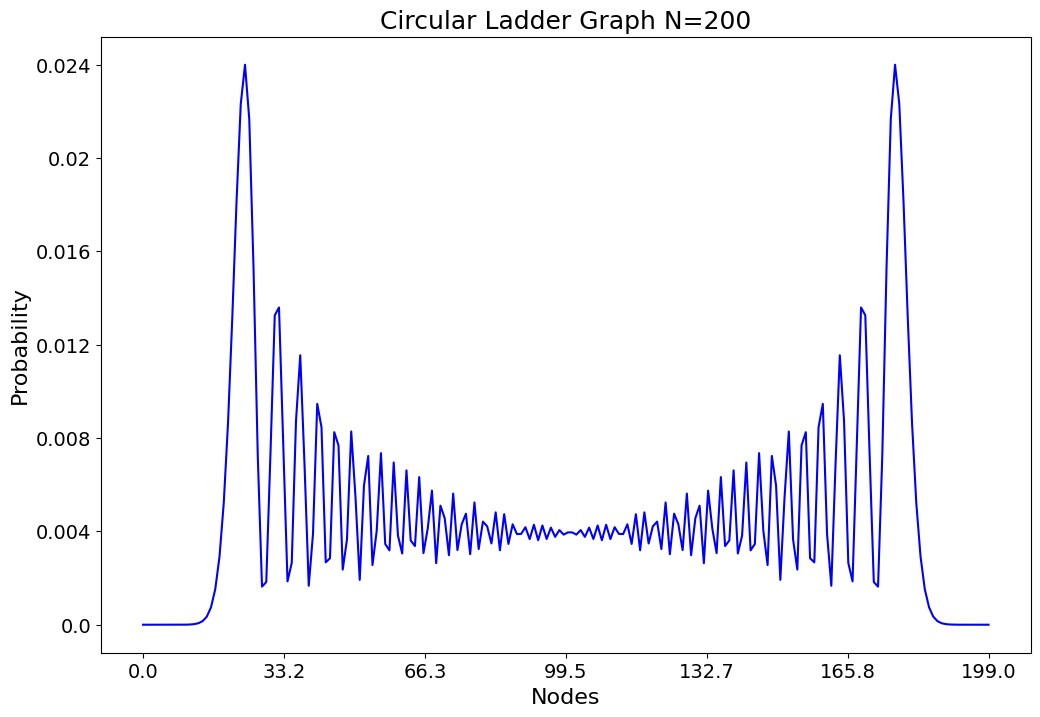

In [16]:
from utils.plotTools import plot_qwak

n = 200
t= 40
initNodes = [n//2,n//2 +1]
graph = nx.cycle_graph(n)


initState = CupyState(n=n,nodeList=initNodes)
initState.buildState()


operator = CupyOperator(graph)
operator.buildDiagonalOperator(t)

quantumWalk = CupyQuantumWalk(initState,operator)
quantumWalk.buildWalk()
finalState = quantumWalk.getFinalState()
# print(type(finalState
          # ))

probDist = CupyProbabilityDistribution(finalState)
probDist.buildProbDist()
# print(probDist.getProbVec())

params = {
    'font_size' : 14,
    'figsize': (12, 8),
    'plot_title' : f'Circular Ladder Graph N={n}',
    'x_label' : 'Nodes',
    'y_label' : "Probability",
    # 'legend_labels' : alphaLabelList,
    # 'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    # 'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['-', '-','-.' ],
    'save_path' : f'Output/UndirectedDynamics/circularLadderDynamics_N{n}_TMAX{round(t,2)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    'x_num_ticks' : 7,
    'y_num_ticks' : 7,
    'x_round_val' : 1,
    'y_round_val' : 3,
    'title_font_size': 20,
    'xlabel_font_size': 22,
    'ylabel_font_size': 22,
    'legend_font_size': 14,
    'legend_title_font_size': 14,
    'tick_font_size': 18,
}

probVecNP = cp.asnumpy(probDist.getProbVec())

plot_qwak(x_value_matrix = list(range(0,n)), y_value_matrix = probVecNP,**params)

400
400


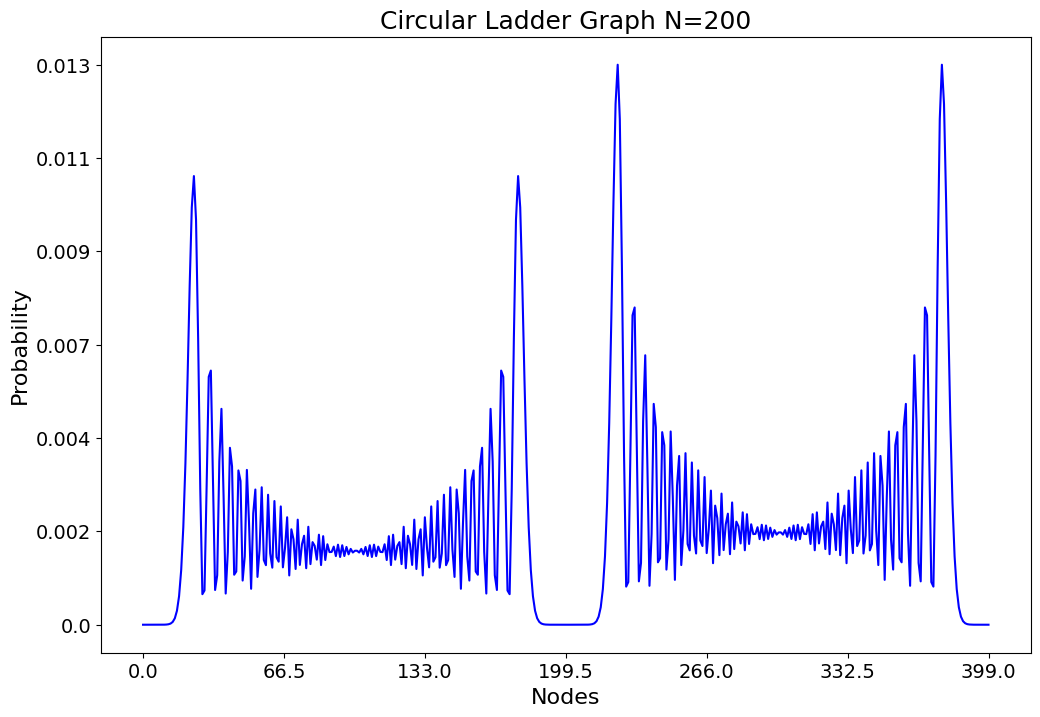

In [17]:
from utils.plotTools import plot_qwak

n = 200
t= 40
initNodes = [n//2,n//2 +1]
graph = graph = nx.circular_ladder_graph(n)

initState = CupyState(n=2*n,nodeList=initNodes)
initState.buildState()
print(len(initState.getStateVec()))


operator = CupyOperator(graph)
operator.buildDiagonalOperator(t)

print(len(operator.getOperator()))

quantumWalk = CupyQuantumWalk(initState,operator)
quantumWalk.buildWalk()
finalState = quantumWalk.getFinalState()
# print(type(finalState
          # ))

probDist = CupyProbabilityDistribution(finalState)
probDist.buildProbDist()
# print(probDist.getProbVec())




    
    
params = {
    'font_size' : 14,
    'figsize': (12, 8),
    'plot_title' : f'Circular Ladder Graph N={n}',
    'x_label' : 'Nodes',
    'y_label' : "Probability",
    # 'legend_labels' : alphaLabelList,
    # 'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    # 'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['-', '-','-.' ],
    'save_path' : f'Output/UndirectedDynamics/circularLadderDynamics_N{n}_TMAX{round(t,2)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    'x_num_ticks' : 7,
    'y_num_ticks' : 7,
    'x_round_val' : 1,
    'y_round_val' : 3,
    'title_font_size': 20,
    'xlabel_font_size': 22,
    'ylabel_font_size': 22,
    'legend_font_size': 14,
    'legend_title_font_size': 14,
    'tick_font_size': 18,
}

probVecNP = cp.asnumpy(probDist.getProbVec())

plot_qwak(x_value_matrix = list(range(0,2*n)), y_value_matrix = probVecNP,**params)

# QWAK

In [18]:
from __future__ import annotations
from typing import Union

import networkx as nx
import cupy as cp
import copy
import json
from qwak.Errors import (
    StateOutOfBounds,
    NonUnitaryState,
    UndefinedTimeList,
    EmptyProbDistList,
    MissingNodeInput,
    MissingGraphInput,
)
from qwak.State import State
from qwak.Operator import Operator
from qwak.QuantumWalk import QuantumWalk
from qwak.ProbabilityDistribution import (
    ProbabilityDistribution,
)


class CupyQWAK:
    def __init__(
            self,
            graph: nx.Graph,
            time: float = 0,
            timeList: list = None,
            gamma: float = 1,
            initStateList: list = None,
            customStateList: list = None,
            laplacian: bool = False,
            markedElements: list = [],
            qwakId: str = 'userUndef',
    ) -> None:
        self._graph = graph
        self._n = len(self._graph)
        if timeList is not None:
            self._timeList = cp.array([x for x in timeList])
        else:
            self._timeList = cp.array([0]*self._n)
        self._qwakId = qwakId
        self._operator = CupyOperator(
            self._graph,
            time=time,
            gamma=gamma,
            laplacian=laplacian,
            markedElements=markedElements)
        self._initState = CupyState(
            self._n,
            nodeList=initStateList,
            customStateList=customStateList)
        self._quantumWalk = CupyQuantumWalk(self._initState, self._operator)
        self._probDist = CupyProbabilityDistribution(
            self._quantumWalk.getFinalState())
        self._probDistList = cp.array([])


    def runWalk(
            self,
            time: float = 0,
            initStateList: list = None,
            customStateList: list = None) -> None:
        try:
            self._initState.buildState(
                nodeList=initStateList, customStateList=customStateList
            )
        except StateOutOfBounds as stOBErr:
            raise stOBErr
        except NonUnitaryState as nUErr:
            raise nUErr
        self._operator.buildDiagonalOperator(time=time)
        self._quantumWalk.buildWalk(self._initState, self._operator)
        self._probDist.buildProbDist(self._quantumWalk.getFinalState())
        
    def setProbDist(self, newProbDist: ProbabilityDistribution) -> None:
        self._probDist.setProbDist(newProbDist)

    def getProbDist(self) -> ProbabilityDistribution:
        return self._probDist

    def getProbDistList(self) -> list:
        return self._probDistList

    def setProbDistList(self, newProbDistList: list) -> None:
        self._probDistList = newProbDistList

    def getProbVec(self) -> cp.ndarray:
        return self._probDist.getProbVec()

    

In [19]:
# def runExpmWalk(
#             self,
#             time: float = 0,
#             initStateList: list = None,
#             customStateList: list = None) -> None:
#         try:
#             self._initState.buildState(
#                 nodeList=initStateList, customStateList=customStateList
#             )
#         except StateOutOfBounds as stOBErr:
#             raise stOBErr
#         except NonUnitaryState as nUErr:
#             raise nUErr
#         self._operator.buildExpmOperator(time=time)
#         self._quantumWalk.buildWalk(self._initState, self._operator)
#         self._probDist.buildProbDist(self._quantumWalk.getFinalState())

#     def runMultipleWalks(
#             self,
#             timeList: list = None,
#             initStateList: list = None,
#             customStateList: list = None) -> None:

#         self._probDistList = []
#         if timeList is not None:
#             self._timeList = timeList
#         elif self._timeList is None:
#             raise UndefinedTimeList(f"TimeList is {self._timeList}.")
#         for time in self._timeList:
#             self.runWalk(
#                 time=time,
#                 initStateList=initStateList,
#                 customStateList=customStateList)
#             self._probDistList.append(copy.deepcopy(self.getProbDist()))

#     def runMultipleExpmWalks(
#             self,
#             timeList: list = None,
#             initStateList: list = None,
#             customStateList: list = None) -> None:

#         self._probDistList = []
#         if timeList is not None:
#             self._timeList = timeList
#         elif self._timeList is None:
#             raise UndefinedTimeList(f"TimeList is {self._timeList}.")
#         for time in self._timeList:
#             self.runExpmWalk(
#                 time=time,
#                 initStateList=initStateList,
#                 customStateList=customStateList)
#             self._probDistList.append(copy.deepcopy(self.getProbDist()))

#     def resetWalk(self) -> None:
#         """Resets the components of a walk."""
#         self._initState.resetState()
#         self._operator.resetOperator()
#         self._quantumWalk.resetWalk()
#         self._probDist.resetProbDist()
#         self._probDistList = []
#         self._walkList = []

#     def setDim(
#             self,
#             newDim: int,
#             graphStr: str = None,
#             graph: nx.Graph = None,
#             initStateList: list = None) -> None:
#         self._n = newDim
#         if graphStr is not None:
#             self._graph = eval(f"{graphStr}({self._n})")
#             self._n = len(self._graph)
#         elif graph is not None:
#             self._graph = graph
#             self._n = len(self._graph)
#         else:
#             raise MissingGraphInput(
#                 f"You tried to set QWAK dim without providing a graph with updated dimensions: {self._graph}")

#         self._initState.setDim(newDim, newNodeList=initStateList)
#         self._operator.setDim(newDim, self._graph)
#         self._quantumWalk.setDim(newDim)
#         self._probDist.setDim(newDim)

#     def getDim(self) -> int:

#         return self._n

#     def setGraph(self, newGraph: nx.Graph, initStateList=None) -> None:

#         self._graph = newGraph
#         self._n = len(self._graph)

#     def getGraph(self) -> nx.Graph:
    
#         return self._graph

#     def setCustomGraph(self, customAdjMatrix: cp.ndarray) -> None:
#         self._graph = nx.from_numpy_matrix(cp.asnumpy(customAdjMatrix))
#         self.setGraph(newGraph=self._graph)
#         self._initStateList = [self._n // 2]
#         self.setDim(
#             self._n,
#             graph=self._graph,
#             initStateList=self._initStateList)

#     def setInitState(self, newInitState: State) -> None:
#         self._initState.setState(newInitState)
#         self._initStateList = self._initState.getNodeList()

#     def getInitState(self) -> State:
#         return self._initState

#     def setTime(self, newTime: float) -> None:
#         self._operator.setTime(newTime)

#     def setTimeList(self, newTimeList: list) -> None:
#         timeList = cp.linspace(
#             newTimeList[0], newTimeList[1], int(
#                 newTimeList[1]))
#         self._timeList = timeList.tolist()

#     def getTime(self) -> float:
#         return self._operator.getTime()

#     def getTimeList(self) -> float:
#         return self._timeList

#     def setAdjacencyMatrix(
#             self, newAdjMatrix: cp.ndarray, initStateList: list = None
#     ) -> None:
#         self._n = len(self._operator.getAdjacencyMatrix())
#         self._operator.setAdjacencyMatrix(newAdjMatrix)
#         self._initState = State(self._n, initStateList)
#         self._quantumWalk = QuantumWalk(self._initState, self._operator)
#         self._probDist = ProbabilityDistribution(
#             self._quantumWalk.getFinalState())

#     def getAdjacencyMatrix(self) -> cp.ndarray:
#         return self._operator.getAdjacencyMatrix()

#     def setHamiltonian(self, newHamiltonian: cp.ndarray) -> None:
#         self._operator.setHamiltonian(newHamiltonian)

#     def getHamiltonian(self) -> cp.ndarray:
#         return self._operator.getHamiltonian()

#     def setOperator(self, newOperator: Operator) -> None:

#         self._operator.setOperator(newOperator)

#     def getOperator(self) -> Operator:
#         return self._operator

#     def setWalk(self, newWalk: State) -> None:
#         self._quantumWalk.setWalk(newWalk)

#     def getWalk(self) -> QuantumWalk:
#         return self._quantumWalk

#     def getFinalState(self) -> State:
#         return self._quantumWalk.getFinalState()

#     def getAmpVec(self) -> cp.ndarray:
#         return self._quantumWalk.getAmpVec()

#     def setProbDist(self, newProbDist: ProbabilityDistribution) -> None:
#         self._probDist.setProbDist(newProbDist)

#     def getProbDist(self) -> ProbabilityDistribution:
#         return self._probDist

#     def getProbDistList(self) -> list:
#         return self._probDistList

#     def setProbDistList(self, newProbDistList: list) -> None:
#         self._probDistList = newProbDistList

#     def getProbVec(self) -> cp.ndarray:
#         return self._probDist.getProbVec()

#     def getProbVecList(self) -> list:
#         return [probDist.getProbVec()
#                 for probDist in self._probDistList]

#     def searchNodeAmplitude(self, searchNode: int) -> complex:
#         return self._quantumWalk.searchNodeAmplitude(searchNode)

#     def searchNodeProbability(self, searchNode: int) -> float:
#         return self._probDist.searchNodeProbability(searchNode)

### Numpy QWAK

In [20]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import timeit
import sympy as sp
from sympy.abc import pi
from math import sqrt, ceil, pow
from utils.plotTools import plot_qwak
from qwak.qwak import QWAK

t = 0.5
n = 4
graph = nx.cycle_graph(n)
initNodes = [0,1,2,3]

qw = QWAK(graph)
qw.runWalk(t, initNodes)
print(qw.getProbVec())


[0.25 0.25 0.25 0.25]


### Cupy QWAK

In [21]:
t = 0.5
n = 4
graph = nx.cycle_graph(n)
initNodes = [0,1,2,3]

qw = CupyQWAK(graph)
qw.runWalk(t, initNodes)
print(qw.getProbVec())
print(type(qw.getProbVec()))

[0.25 0.25 0.25 0.25]
<class 'cupy.ndarray'>


# Comparing Both QWAK Implementations

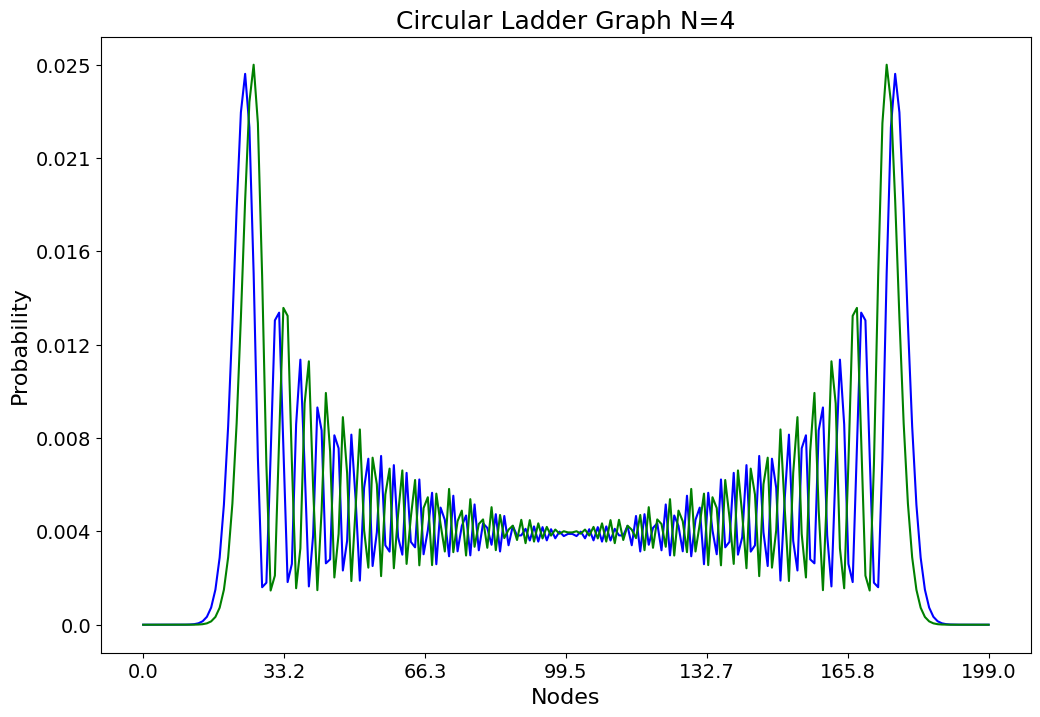

In [22]:
npqw = QWAK(nx.cycle_graph(200))
cpqw = CupyQWAK(nx.cycle_graph(200))

npqw.runWalk(40,[100,101])
cpqw.runWalk(39,[100,101])

params = {
    'font_size' : 14,
    'figsize': (12, 8),
    'plot_title' : f'Circular Ladder Graph N={n}',
    'x_label' : 'Nodes',
    'y_label' : "Probability",
    # 'legend_labels' : alphaLabelList,
    # 'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    # 'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['-', '-','-.' ],
    'save_path' : f'Output/UndirectedDynamics/circularLadderDynamics_N{n}_TMAX{round(t,2)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    'x_num_ticks' : 7,
    'y_num_ticks' : 7,
    'x_round_val' : 1,
    'y_round_val' : 3,
    'title_font_size': 20,
    'xlabel_font_size': 22,
    'ylabel_font_size': 22,
    'legend_font_size': 14,
    'legend_title_font_size': 14,
    'tick_font_size': 18,
}

probVecNP = cp.asnumpy(probDist.getProbVec())
nodeList = list(range(0,200))
probVecList = [cp.asnumpy(npqw.getProbVec()),cp.asnumpy(cpqw.getProbVec())]
plot_qwak(x_value_matrix = [nodeList]*2,y_value_matrix = probVecList ,**params)

## Benchmarking

In [26]:
import time

n=2000
t=40
graph = nx.cycle_graph(n)
initNodes = [n//2, n//2 + 1]

In [27]:

start_time = time.time()
npqw = QWAK(graph)
npqw.runWalk(t,initNodes)
probDistNumpy = npqw.getProbVec()
end_time = time.time()

numpy_time = end_time - start_time
print(f"NumPy QWAK execution time: {numpy_time} seconds")

NumPy QWAK execution time: 2.4051475524902344 seconds


In [28]:

start_time = time.time()
cpqw = CupyQWAK(graph)
cpqw.runWalk(t,initNodes)
probDistCupy = cpqw.getProbVec()

end_time = time.time()
cupy_time = end_time - start_time

print(f"CuPy QWAK execution time: {cupy_time} seconds")

CuPy QWAK execution time: 1.1090309619903564 seconds


In [29]:
import numpy as np

# Convert the CuPy array to a NumPy array
probDistCupy_toNp= cp.asnumpy(probDistCupy)

# Compare the two arrays using np.allclose
are_close = np.allclose(probDistNumpy, probDistCupy_toNp, atol=1e-5)

# Print the result of the comparison
print(f"Are the two arrays approximately equal? {are_close}")

Are the two arrays approximately equal? True
